<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº4
#### Joaquin Gomez Lucero y Milena Waichman Scigliano


# Introduccion


En esta experiencia se estudió el desempeño de distintos estimadores de amplitud y frecuencia aplicados a una señal senoidal con ruido blanco gaussiano aditivo (AWGN).  
El objetivo fue analizar cómo afectan el nivel de ruido y la elección de la ventana espectral sobre la precisión estadística de dichos estimadores, observando sus valores de sesgo y varianza.

Se trabajó con una señal senoidal de amplitud $A_0 = 2$ y potencia $P_s = A_0^2 / 2 = 2\,\text{W}$, muestreada a una frecuencia de $f_s = 1000\,\text{Hz}$ con un total de $N = 1000$ muestras por realización.  
Se generó un conjunto de $R = 200$ realizaciones independientes, cada una con una ligera variación aleatoria en su frecuencia, modelada mediante un parámetro $f_r$ uniformemente distribuido en el rango $[-2, 2]$ bins de frecuencia.  
De esta manera se simuló una senoidal estocástica con *jitter en frecuencia* y ruido gaussiano aditivo.

El ruido se ajustó para obtener relaciones señal–ruido de $SNR = 3\,\text{dB}$ y $SNR = 10\,\text{dB}$, generando así dos escenarios.  
La desviación estándar del ruido se calculó en función de la potencia de la señal, según $$\sigma_n = \sqrt{P_s \cdot 10^{-SNR_{dB}/10}}$$

Cada señal se representó en forma matricial ($N \times R$), donde cada columna corresponde a una realización independiente.  
A cada una se le aplicaron diferentes ventanas espectrales: Rectangular (por defecto), Flattop, Blackman–Harris y Hamming.  
Posteriormente se calculó la *Transformada Rápida de Fourier (FFT)* con *zero padding* de $10N$ puntos para mejorar la resolución espectral y se implementaron los estimadores de amplitud y frecuencia, sobre los cuales se evaluaron el sesgo y la varianza.

# 1) Densidad Espectral de Potencia

A partir de una función senoidal se generaron tres señales con frecuencias distintas:
$$fs_1=N/4\cdot \Delta F$$  $$fs_2=(N/4+0,25) \cdot \Delta F$$  $$fs_3=(N/4+0,5) \cdot \Delta F$$ 
Estas señales fueron normalizadas utilizando su media y desvío estándar.
Posteriormente, se aplicó la Transformada Rápida de Fourier (FFT) para pasar al dominio de las frecuencias y poder calcular su Densidad Espectral de Potencia (PSD). La FFT se define como:
$$ X[k]=\sum_{n=0}^{N-1} x[n]e^{-j2\pi kn/N}$$
Como se explicó en la introducción, la PSD describe cómo se distribuye la potencia de la señala lo largo de las distintas frecuencias. Para su estimación se utilizó el periodograma, que consiste en analizar la energía de la señal en cada bin de la FFT (cada “cajoncito” de frecuencia). El cálculo se realiza mediante:
$$PSD(f_k)=\frac {1}{N}|X[k]|^2$$
De esta forma, el periodograma obtenido permite visualizar la distribución espectral de cada señal y observar fenómenos como el desparramo espectral cuando la frecuencia no coincide exactamente con un bin de la FFT.

In [1]:

import numpy as np
from numpy.fft import fft
import scipy.signal.windows as window
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
np.random.seed(7)

#%% DATOS
N = 1000
fs = N
deltaF = fs/N
Npadding = 10* N
deltaF_Padding = fs/Npadding

Ts = 1/fs
k = np.arange(N)*deltaF
t = np.arange(N)*Ts

#a0 = np.sqrt(2)
a0 = 2
R = 200
fr = np.random.uniform(-2, 2, R)
f1 = (N / 4 + fr) * deltaF
PP = a0
t = t.reshape(-1,1)

pot_senal = (a0**2)/2

matriz_t = np.tile(t, (1,R))
matriz_ff = np.tile(f1, (N,1))

freq = np.fft.fftfreq(Npadding, d = 1/fs)

#%% ARMADO DE MATRIZ DE SENOIDALES Y VENTANAS. 
matriz_x = a0 * np.sin(2 * np.pi * matriz_ff * matriz_t)

flattop = window.flattop(N).reshape((-1,1))
bmh = window.blackmanharris(N).reshape((-1,1))
hamming = window.hamming(N).reshape((-1,1))

# matriz_x: N x R  (solo senoidal, SIN ruido)
P_signal_cols = (1/N) * np.sum(matriz_x**2, axis=0)   # potencia de cada realización
P_signal_mean = P_signal_cols.mean()

## CHEQUEO DE POTENCIA 
print("Potencias señal (min / mean / max):",
      P_signal_cols.min(), P_signal_mean, P_signal_cols.max())

# ¿Está normalizada a 1?
print("¿Potencia ~ 2 en TODAS las columnas?",
      np.allclose(P_signal_cols, 2.0, rtol=1e-3, atol=1e-3))

## FUNCIONES PARA ARMAR LAS TABLAS DE VALORES.
def _fmt(x):
    # Asegura float y formato científico prolijo
    return f"{np.asarray(x, dtype=float): .6e}"

def _print_block(title, rows):
    print(f"\n[{title}]")
    print(f"{'Ventana':<18}{'Sesgo':>16}{'Varianza':>16}{'Desvío':>16}")
    print("-"*66)
    for (vent, bias, var) in rows:
        std = np.sqrt(np.maximum(var, 0.0))  # por estabilidad numérica
        print(f"{vent:<18}{_fmt(bias):>16}{_fmt(var):>16}{_fmt(std):>16}")




Potencias señal (min / mean / max): 1.998000006961332 1.9989323414757398 1.999999982576173
¿Potencia ~ 2 en TODAS las columnas? True


Para ambas condiciones de ruido se verificó primero la correcta normalización de la señal y el escalado del ruido.  
La potencia promedio medida resulto ser $P_s \approx 2\,\text{W}$, en concordancia con el valor teórico calculado como $P_s=A_0^2/2$. 
Esto confirma que la generación de la señal fue correcta y que las realizaciones mantienen una potencia constante, independientemente del nivel de ruido aplicado.

### 2.1 Estimadores de amplitud y frecuencia

Para la estimación de la amplitud se implementaron dos métodos:

1. **Estimador por pico**: consiste en tomar el valor máximo del módulo del espectro $|X[k]|$ y y normalizarlo mediante el *coherent gain* (CG) correspondiente a cada tipo de ventana. Este factor corrige la atenuación introducida por la ventana durante el cálculo de la FFT.   
2. **Estimador por bin fijo ($N/4$)**: se evalúa la amplitud en el bin teórico asociado a la frecuencia fundamental. Este método permite observar el efecto de *scalloping*, que se manifiesta cuando la frecuencia de la señal no coincide exactamente con un bin de la FFT, provocando una subestimación de la amplitud.

En ambos casos se calcularon el sesgo, la varianza y el desvío estándar de las estimaciones para cada tipo de ventana espectral.

Para la estimación de la frecuencia, se utilizó el índice del máximo del espectro en la mitad positiva de la FFT:
$$\hat{f} = \arg\max_{k>0} |X[k]|$$
A partir de este valor, se calcularon los errores por realización respecto de la frecuencia verdadera (afectada por jitter):
$$e_f = \hat{f} - f_{\text{true}}$$
y se determinaron el sesgo y la varianza de dichos errores.

In [2]:
#%% ESTE FOR LO HICIMOS PARA ARMAR LA TABLA PARA SNR = 3 Y SNR = 10
for SNRdb in [3, 10]:
    print(f"\n===== RESULTADOS PARA SNR = {SNRdb} dB =====")
    sigma_ruido = np.sqrt(pot_senal * 10**(-SNRdb/10))
    matriz_ruido = np.random.normal(0, sigma_ruido , size=(N, R))
    matriz_xn = matriz_x + matriz_ruido

    xx_vent_flt = matriz_xn * flattop
    xx_vent_bmh = matriz_xn * bmh
    xx_vent_hmg = matriz_xn * hamming

    # FFT 
    matriz_Xn1 = (1/N) * fft(matriz_xn, n = Npadding, axis = 0)
    matriz_Xn2 = (1/N) * fft(xx_vent_flt, n = Npadding, axis = 0)
    matriz_Xn3 = (1/N) * fft(xx_vent_bmh, n = Npadding, axis = 0)
    matriz_Xn4 = (1/N) * fft(xx_vent_hmg, n = Npadding, axis = 0)

    P_sig = np.mean(matriz_x**2)
    P_n   = np.mean(matriz_ruido**2)
    SNR_meas_db = 10*np.log10(P_sig / P_n)
    Ps_cols = (1/N)*np.sum(matriz_x**2, axis=0)
    Pn_cols = (1/N)*np.sum(matriz_ruido**2, axis=0)
    SNR_cols_db = 10*np.log10(Ps_cols / Pn_cols)
    print(f"SNR medido (global): {SNR_meas_db:.2f} dB")
    print(f"SNR medido (mean±std por realización): {SNR_cols_db.mean():.2f} ± {SNR_cols_db.std():.2f} dB")
#%%    ESTIMADORES DE AMPLITUD DE DOS FORMAS
    cg_rect = 1.0
    cg_flt  = flattop.mean()
    cg_bmh  = bmh.mean()
    cg_hmg  = hamming.mean()

    # # Estimador de amplitud (valor del pico en cada columna)
    amp_est1 = 2*np.max(np.abs(matriz_Xn1), axis=0) / cg_rect
    amp_est2 = 2*np.max(np.abs(matriz_Xn2), axis=0) /cg_flt        
    amp_est3 = 2*np.max(np.abs(matriz_Xn3), axis=0) /cg_bmh      
    amp_est4 = 2*np.max(np.abs(matriz_Xn4), axis=0) /cg_hmg    

    sesgo_rect = np.mean(amp_est1) - a0
    sesgo_flat = np.mean(amp_est2) - a0
    sesgo_bmh  = np.mean(amp_est3) - a0
    sesgo_hmg  = np.mean(amp_est4) - a0

    var_rect = np.var(amp_est1, ddof=0)
    var_flat = np.var(amp_est2, ddof=0)
    var_bhm  = np.var(amp_est3, ddof=0)
    var_hmg  = np.var(amp_est4, ddof=0)

    #estimador pero solamente en la feta de N//4
    amp_est1_bin = 2*np.abs(matriz_Xn1[Npadding//4, :]) / cg_rect
    amp_est2_bin = 2*np.abs(matriz_Xn2[Npadding//4, :]) / cg_flt
    amp_est3_bin = 2*np.abs(matriz_Xn3[Npadding//4, :]) / cg_bmh
    amp_est4_bin = 2*np.abs(matriz_Xn4[Npadding//4, :]) / cg_hmg    

    sesgo_rect_bin = np.mean(amp_est1_bin) - a0
    sesgo_flat_bin = np.mean(amp_est2_bin) - a0
    sesgo_bmh_bin  = np.mean(amp_est3_bin) - a0
    sesgo_hmg_bin  = np.mean(amp_est4_bin) - a0

    var_rect_bin = np.var(amp_est1_bin, ddof=0)
    var_flat_bin = np.var(amp_est2_bin, ddof=0)
    var_bhm_bin  = np.var(amp_est3_bin, ddof=0)
    var_hmg_bin  = np.var(amp_est4_bin, ddof=0)

#%% ESTIMADORES DE FRECUENCIA DE 1 MANERA 
    # Parte positiva de cada ventana
    X1p = matriz_Xn1[:Npadding//2+1, :]
    X2p = matriz_Xn2[:Npadding//2+1, :]
    X3p = matriz_Xn3[:Npadding//2+1, :]
    X4p = matriz_Xn4[:Npadding//2+1, :]

    idx1 = np.argmax(np.abs(X1p), axis=0)
    idx2 = np.argmax(np.abs(X2p), axis=0)
    idx3 = np.argmax(np.abs(X3p), axis=0)
    idx4 = np.argmax(np.abs(X4p), axis=0)

    frec_est1 = idx1 * deltaF_Padding #- f1
    frec_est2 = idx2 * deltaF_Padding #- f1
    frec_est3 = idx3 * deltaF_Padding #- f1
    frec_est4 = idx4 * deltaF_Padding #- f1

    # Frecuencia verdadera por realización (vector R,)
    #f1  # (= (N/4 + fr) * deltaF)

    # Errores por realización
    err1 = frec_est1 - f1
    err2 = frec_est2 - f1
    err3 = frec_est3 - f1
    err4 = frec_est4 - f1

    sesgo= np.mean(frec_est1) - np.mean(f1)

    # Sesgo y varianza muestral, SON ESCALARES. 
    sesgo_rect1 = float(err1.mean());  var_rect1 = float(err1.var(ddof=0))
    sesgo_flat2 = float(err2.mean());  var_flat2 = float(err2.var(ddof=0))
    sesgo_bmh3  = float(err3.mean());  var_bhm3  = float(err3.var(ddof=0))
    sesgo_hmg4  = float(err4.mean());  var_hmg4  = float(err4.var(ddof=0))
    
#%%TABLA DE VALORES

    print(f"\n=== TABLA SESGO Y VARIANZA — SNR = {SNRdb} dB ===")
    
    # --- Amplitud — Pico (máximo FFT ×2/CG) ---
    rows_amp_peak = [
        ("Rectangular",     sesgo_rect,     var_rect),
        ("Flattop",         sesgo_flat,     var_flat),
        ("Blackman-Harris", sesgo_bmh,      var_bhm),
        ("Hamming",         sesgo_hmg,      var_hmg),
    ]
    _print_block("AMPLITUD — Pico (×2/CG)", rows_amp_peak)
    
    # --- Amplitud — Bin fijo fs/4 (scalloping) ---
    rows_amp_bin = [
        ("Rectangular",     sesgo_rect_bin,     var_rect_bin),
        ("Flattop",         sesgo_flat_bin,     var_flat_bin),
        ("Blackman-Harris", sesgo_bmh_bin,      var_bhm_bin),
        ("Hamming",         sesgo_hmg_bin,      var_hmg_bin),
    ]
    _print_block("AMPLITUD — Bin fijo fs/4", rows_amp_bin)
    
    # --- Frecuencia — Argmax (f̂ − f_true) ---
    rows_freq = [
        ("Rectangular",     sesgo_rect1,    var_rect1),
        ("Flattop",         sesgo_flat2,    var_flat2),
        ("Blackman-Harris", sesgo_bmh3,     var_bhm3),
        ("Hamming",         sesgo_hmg4,     var_hmg4),
    ]
    _print_block("FRECUENCIA — Argmax (f̂ − f_true)", rows_freq)


===== RESULTADOS PARA SNR = 3 dB =====
SNR medido (global): 3.01 dB
SNR medido (mean±std por realización): 3.01 ± 0.18 dB

=== TABLA SESGO Y VARIANZA — SNR = 3 dB ===

[AMPLITUD — Pico (×2/CG)]
Ventana                      Sesgo        Varianza          Desvío
------------------------------------------------------------------
Rectangular           2.352476e-04    2.356997e-03    4.854891e-02
Flattop               1.777426e-02    6.873421e-03    8.290610e-02
Blackman-Harris       1.963747e-03    3.916823e-03    6.258452e-02
Hamming               1.000016e-03    2.834239e-03    5.323757e-02

[AMPLITUD — Bin fijo fs/4]
Ventana                      Sesgo        Varianza          Desvío
------------------------------------------------------------------
Rectangular          -1.228430e+00    4.510890e-01    6.716316e-01
Flattop              -1.598448e-01    5.006292e-02    2.237474e-01
Blackman-Harris      -6.694062e-01    2.799007e-01    5.290564e-01
Hamming              -1.034085e+00    5.

Los resultados obtenidos para los estimadores de amplitud muestran que:

- Para $SNR = 3\,\text{dB}$, las ventanas **Rectangular** y **Hamming** presentan las menores varianzas, mientras que **Flattop** exhibe una mayor dispersión pero con un sesgo reducido.  
- En el caso del bin fijo, todas las ventanas se ven afectadas por el efecto de *scalloping*, lo que introduce un sesgo negativo apreciable. No obstante, la ventana **Flattop** logra compensar parcialmente ese error, presentando la menor desviación media (≈ −0.17 tanto para 3 dB como para 10 dB).  
- Al aumentar el SNR la relación señal–ruido a $SNR=10 dB$, la varianza de todos los estimadores disminuye, indicando una mayor precisión.

En cuanto a los estimadores de frecuencia:

- Las ventanas **Rectangular**, **Hamming** y **Blackman–Harris** presentan varianzas bajas (del orden de $10^{-3}$) y sesgos despreciables (< 0.01 Hz).  
- En contraste, **Flattop**, presenta una varianza considerablemente mayor debido a su lóbulo principal más ancho, que reduce la resolución en frecuencia.  
- Al incrementarse el SNR, la dispersión de los errores disminuye en todos los casos, en concordancia con el comportamiento esperado teóricamente.

## 2.2 Histogramas

En primer lugar, se grafican las señales temporales correspondientes a las distintas ventanas aplicadas (rectangular, Flattop, Blackman–Harris y Hamming) lo que permite visualizar cómo cada ventana modifica la forma temporal de la señal senoidal original.

El **jitter** representa pequeñas variaciones aleatorias en los instantes de muestreo de la señal, provocando que los picos no se alineen perfectamente en el tiempo. Estas fluctuaciones, generalmente inducidas por el ruido, suelen seguir una distribución normal (gaussiana).

Un **histograma** es una representación gráfica que muestra cómo se distribuyen los valores de un conjunto de datos. Se divide el rango de valores posibles en intervalos (bins) y se cuenta cuántas veces los datos caen dentro de cada intervalo. El eje $x$ indica los valores posibles (por ejemplo, amplitud o frecuencia estimada) y el eje $y$ representa la frecuencia de ocurrencia.

En este trabajo, los histogramas permiten visualizar la dispersión de los estimadores de amplitud y frecuencia obtenidos a partir de múltiples realizaciones de la señal con ruido:

- Para los **estimadores de amplitud**, un histograma más concentrado alrededor del valor real $a_0$ (línea roja) indica menor varianza y mayor precisión.
- Para los **estimadores de frecuencia**, la distribución muestra cómo se dispersan las estimaciones alrededor de la frecuencia teórica $f_0=\frac{f_s}{4}$

En resumen, los histogramas permiten evaluar de forma visual el sesgo y la varianza de los estimadores: un pico desplazado respecto del valor real indica sesgo, mientras que un histograma ancho indica mayor varianza.

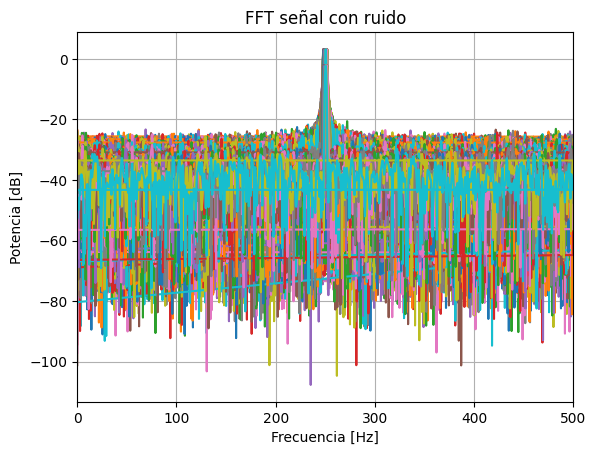

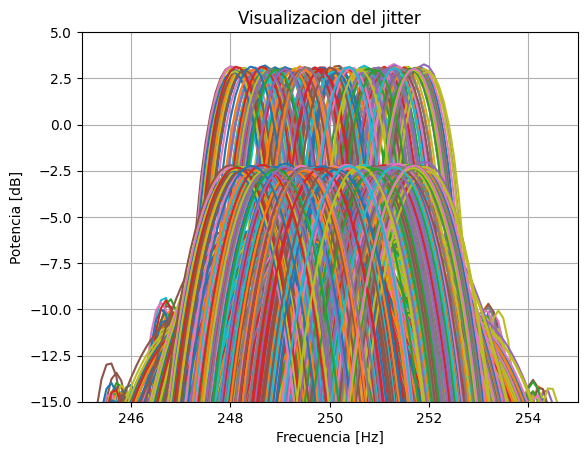

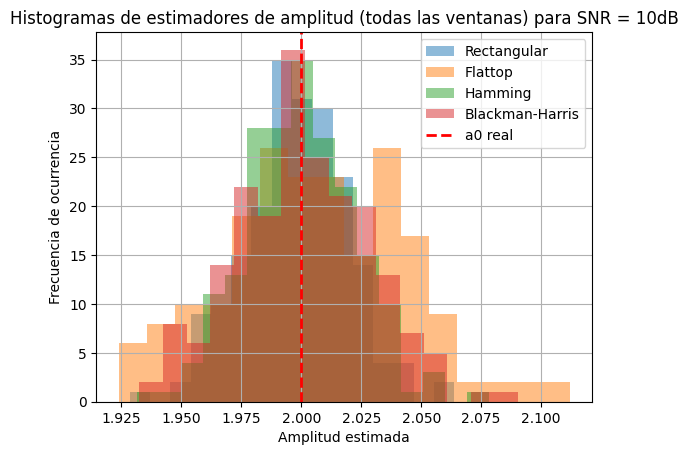

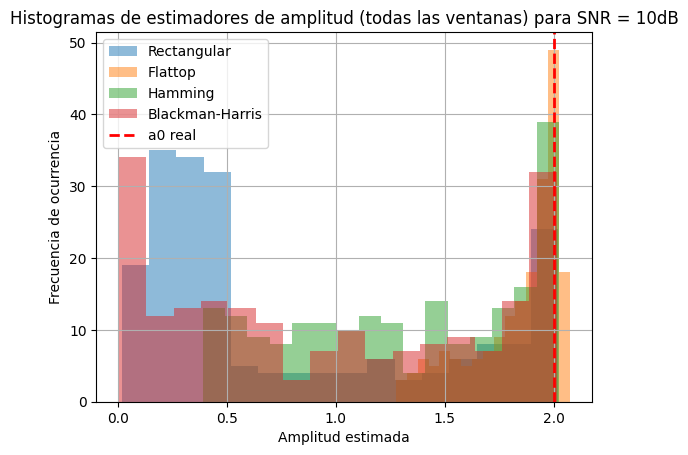

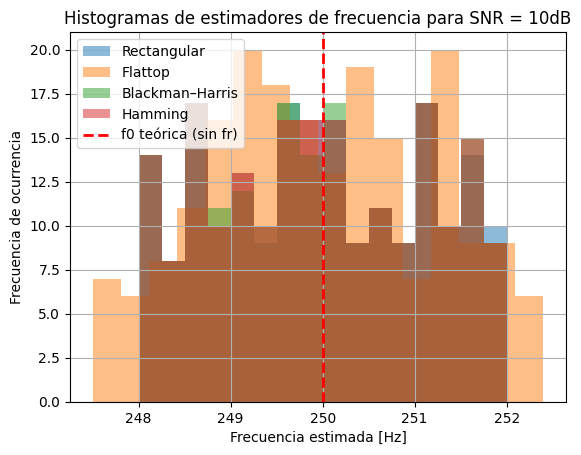

In [9]:
#%% GRAFICOS

plt.figure()
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn1)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn2)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn3)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn4)**2) + 3)
plt.title("FFT señal con ruido")
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.xlim(0,fs/2)
plt.grid(True)

plt.figure()
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn1)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn2)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn3)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn4)**2) + 3)
plt.title("Visualizacion del jitter")
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.xlim(245,255)
plt.ylim(-15,5)
plt.grid(True)

plt.figure()
plt.hist(amp_est1, bins=16, alpha=0.5, label="Rectangular")
plt.hist(amp_est2, bins=16, alpha=0.5, label="Flattop")
plt.hist(amp_est4, bins=16, alpha=0.5, label="Hamming")
plt.hist(amp_est3, bins=16, alpha=0.5, label="Blackman-Harris")
plt.axvline(a0, color='red', linestyle='--', linewidth=2, label="a0 real")
plt.title("Histogramas de estimadores de amplitud (todas las ventanas) para SNR = 10dB")
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia de ocurrencia")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.hist(amp_est1_bin, bins=16, alpha=0.5, label="Rectangular")
plt.hist(amp_est2_bin, bins=16, alpha=0.5, label="Flattop")
plt.hist(amp_est3_bin, bins=16, alpha=0.5, label="Hamming")
plt.hist(amp_est4_bin, bins=16, alpha=0.5, label="Blackman-Harris")
plt.axvline(a0, color='red', linestyle='--', linewidth=2, label="a0 real")
plt.title("Histogramas de estimadores de amplitud (todas las ventanas) para SNR = 10dB")
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia de ocurrencia")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.hist(frec_est1, bins=16, alpha=0.5, label="Rectangular")
plt.hist(frec_est2, bins=16, alpha=0.5, label="Flattop")
plt.hist(frec_est3, bins=16, alpha=0.5, label="Blackman–Harris")
plt.hist(frec_est4, bins=16, alpha=0.5, label="Hamming")
plt.axvline(fs/4, color='red', ls='--', lw=2, label='f0 teórica (sin fr)')
plt.title("Histogramas de estimadores de frecuencia para SNR = 10dB")
plt.xlabel("Frecuencia estimada [Hz]")
plt.ylabel("Frecuencia de ocurrencia")
plt.legend(); plt.grid(True); plt.show()


El efecto de la ventana elegida sobre los estimadores se observa claramente en los histogramas y en los espectros graficados. La ventana **Rectangular** ofrece la mejor precisión en frecuencia pero un control pobre del *leakage*, mientras que **Flattop** proporciona estimaciones de amplitud más exactas (menor sesgo) a costa de una mayor varianza y menor resolución en frecuencia. Las ventanas **Hamming** y **Blackman–Harris** representan un compromiso, ofreciendo buena estabilidad tanto en amplitud como en frecuencia. Además, los histogramas muestran cómo la relación señal–ruido influye en la dispersión: a menor SNR, las estimaciones se dispersan más, y a mayor SNR, las distribuciones se concentran alrededor del valor real, reflejando menor varianza y mejor desempeño del estimador.

# Conclusion

El estudio permitió observar cómo el nivel de ruido y la elección de la ventana espectral influyen directamente en el **sesgo** y la **varianza** de los estimadores de amplitud y frecuencia.

Con un nivel de ruido alto ($SNR = 3\,\text{dB}$), las estimaciones presentan mayor dispersión, mientras que al aumentar el $SNR$ a $10\,\text{dB}$ las varianzas disminuyen significativamente, manteniendo constante el sesgo medio. Esto confirma el comportamiento teórico esperado: un mayor $SNR$ mejora la precisión estadística de los estimadores.

En cuanto a las ventanas:

- **Rectangular** ofreció la mejor resolución en frecuencia, pero con mayor *leakage* y un sesgo de amplitud notable cuando la frecuencia no coincide exactamente en un bin FFT.  
- **Flattop** redujo el sesgo de amplitud en condiciones de *scalloping*, aunque a costa de una mayor varianza y menor resolución frecuencial.  
- **Hamming** y **Blackman–Harris** mostraron un equilibrio adecuado, con buena estabilidad en ambas estimaciones.
Los histogramas y espectros graficados confirmaron visualmente estas tendencias: las distribuciones más concentradas indican menor varianza, y los desplazamientos de los picos respecto del valor real reflejan el sesgo de cada estimador.

En síntesis, la ventana Flattop resulta óptima cuando el objetivo es **medir amplitudes precisas**, mientras que las ventanas Hamming o Blackman–Harris son preferibles para **estimación de frecuencia**.  
El enfoque matricial permitió obtener resultados estadísticamente robustos y verificar experimentalmente los compromisos entre resolución, varianza y sesgo en la estimación espectral.


## Autoevaluacion

*Indicar una opción (marcada con negrita):*

**1. Resolví la tarea con seguridad**
2. Resolví la tarea, pero tengo dudas
3. Resolví la tarea,pero no entendí bien
4. No pude resolverla y no entendí


Responder:

*¿Qué aprendiste al hacer esta tarea?*

En esta tarea aprendimos a hacer un analisis bastante completo de una señal con ruido, el uso de estimadores para calcular amplitud y frecuencia, el grafico con histogramas y la aplicacion de los concepto de probabilidad.

*¿Qué te quedó claro? ¿Qué te sigue costando?*

Tras dedicarle varios dias al codigo y luego al informe, quedo todo bastante claro.

*Indicar si se utilizó IA:*

**Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.**
No usé IA.
*En caso afirmativo, indicar una opción o varias:*

Escritura

**Código**

**Conceptos teorícos**

**Gráficos**

Conclusiones